In [1]:
from api.utils import query_api_for_evidence, evidence_to_df
from api.models import EvidenceQuery
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

In [2]:
OVERWRITE_LATEX_OUTPUT = True

In [3]:
PATH_LATEX_TABLE_OUTPUT = Path(f"../thesis/from_python/tables/experiments/common/")
PATH_LATEX_PLOT_OUTPUT = Path(f"../thesis/from_python/figures/experiments/common/")
PATH_LATEX_TABLE_OUTPUT.mkdir(exist_ok=True, parents=True)
PATH_LATEX_PLOT_OUTPUT.mkdir(exist_ok=True, parents=True)

Ensure that the file is deleted before starting the API

In [4]:
log_file_path = Path("../api.log")

In [5]:
log_file_path.unlink(missing_ok=True)

Run the API using `poetry run api`, must be done outside this notebook AFAIK

In [6]:
query_hl = EvidenceQuery(
    guideline_ids=["hodgkin-lymphom"], sources=["pubmed", "civic", "clinicaltrials"]
)

query_es = EvidenceQuery(
    guideline_ids=["oesophaguskarzinom"], sources=["pubmed", "civic", "clinicaltrials"]
)

In [7]:
REPEAT = 100

for _ in tqdm(range(REPEAT)):
    _ = evidence_to_df(query_api_for_evidence(query_hl))

for _ in tqdm(range(REPEAT)):
    _ = evidence_to_df(query_api_for_evidence(query_es))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
def parse_log_to_df(log_file: Path, log_lines_per_query: int = 12) -> pd.DataFrame:
    log_content = log_file.read_text()
    line_items = [line.split(" - ") for line in log_content.split("\n")]
    df = pd.DataFrame(line_items, columns=["ts", "type", "module", "m1", "m2"])
    df["ts"] = pd.to_datetime(df["ts"])
    df = df.query("module == 'app.py'").reset_index(drop=True)
    df["loop"] = df.groupby(df.index // log_lines_per_query).ngroup()
    df = df.set_index("loop", append=True).swaplevel().sort_index()
    df = df.set_index("m1", append=True)
    df["step_time"] = df.groupby(level=0)["ts"].diff()
    df["elapsed_time"] = df.groupby(level=0)["step_time"].cumsum()
    return df

In [14]:
df = parse_log_to_df(log_file_path)

In [15]:
df_hl = df.loc[:99, :]
df_es = df.loc[100:, :]

In [16]:
df_es = df_es.rename(index=lambda x: x - 100, level=0)

In [17]:
total_run_time_per_loop_hl = (
    df_hl.groupby(level=0)["elapsed_time"].last().dt.total_seconds()
)
total_run_time_per_loop_es = (
    df_es.groupby(level=0)["elapsed_time"].last().dt.total_seconds()
)

In [18]:
retrieval_time_per_loop_hl = (
    df_hl.query("m1 in ['civic', 'pubmed', 'clinicaltrials']")
    .groupby(level=[0, 2])
    .nth(1)["step_time"]
    .unstack("m1")
    .apply(lambda col: col.dt.total_seconds(), axis=1)
)

retrieval_time_per_loop_es = (
    df_es.query("m1 in ['civic', 'pubmed', 'clinicaltrials']")
    .groupby(level=[0, 2])
    .nth(1)["step_time"]
    .unstack("m1")
    .apply(lambda col: col.dt.total_seconds(), axis=1)
)

In [19]:
parsing_time_per_loop_hl = (
    df_hl.query("m1 in ['civic', 'pubmed', 'clinicaltrials']")
    .groupby(level=[0, 2])
    .nth(2)["step_time"]
    .unstack("m1")
    .apply(lambda col: col.dt.total_seconds(), axis=1)
)

parsing_time_per_loop_es = (
    df_es.query("m1 in ['civic', 'pubmed', 'clinicaltrials']")
    .groupby(level=[0, 2])
    .nth(2)["step_time"]
    .unstack("m1")
    .apply(lambda col: col.dt.total_seconds(), axis=1)
)

In [20]:
total_source_time_per_loop_hl = retrieval_time_per_loop_hl + parsing_time_per_loop_hl
total_source_time_per_loop_es = retrieval_time_per_loop_es + parsing_time_per_loop_es

In [21]:
source_to_proper_name_mapping = {
    "civic": "CIViC",
    "pubmed": "PubMed",
    "clinicaltrials": "ClinicalTrials.gov",
}

In [22]:
from matplotlib import pyplot as plt
from evaluation.plotting import set_size

plt.style.use("../thesis.mplstyle")

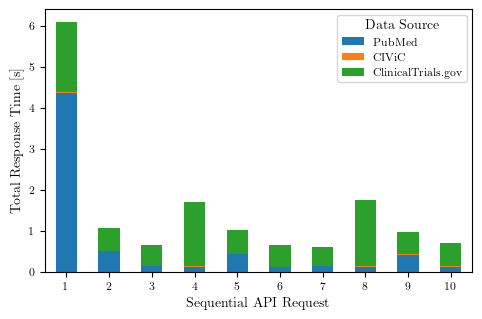

In [19]:
fig, ax = plt.subplots(figsize=set_size(width="thesis"))

total_source_time_per_loop_hl.iloc[:10].rename(
    columns=source_to_proper_name_mapping, index=lambda x: x + 1
).rename_axis(columns={"m1": "Data Source"}).reindex(
    ["PubMed", "CIViC", "ClinicalTrials.gov"], axis=1
).plot(
    kind="bar",
    stacked=True,
    rot=0,
    ylabel="Total Response Time [s]",
    xlabel="Sequential API Request",
    ax=ax,
)

if OVERWRITE_LATEX_OUTPUT:
    fig.savefig(PATH_LATEX_PLOT_OUTPUT / "total_response_time_per_loop.pdf")

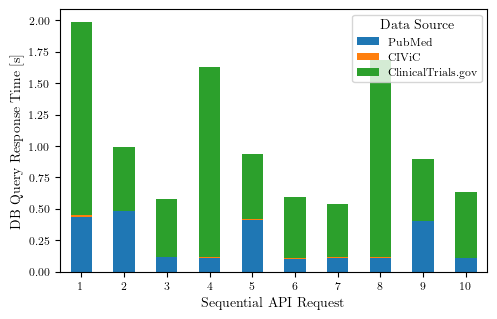

In [20]:
fig, ax = plt.subplots(figsize=set_size(width="thesis"))

retrieval_time_per_loop_hl.iloc[:10].rename(
    columns=source_to_proper_name_mapping, index=lambda x: x + 1
).rename_axis(columns={"m1": "Data Source"}).reindex(
    ["PubMed", "CIViC", "ClinicalTrials.gov"], axis=1
).plot(
    kind="bar",
    stacked=True,
    rot=0,
    ylabel="DB Query Response Time [s]",
    xlabel="Sequential API Request",
    ax=ax,
)

if OVERWRITE_LATEX_OUTPUT:
    fig.savefig(PATH_LATEX_PLOT_OUTPUT / "db_retrieval_time_per_loop.pdf")

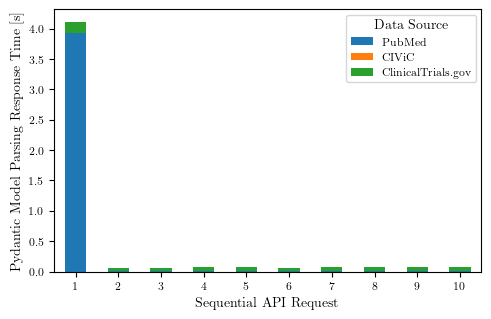

In [21]:
fig, ax = plt.subplots(figsize=set_size(width="thesis"))

parsing_time_per_loop_hl.iloc[:10].rename(
    columns=source_to_proper_name_mapping, index=lambda x: x + 1
).rename_axis(columns={"m1": "Data Source"}).reindex(
    ["PubMed", "CIViC", "ClinicalTrials.gov"], axis=1
).plot(
    kind="bar",
    stacked=True,
    rot=0,
    ylabel="Pydantic Model Parsing Response Time [s]",
    xlabel="Sequential API Request",
    ax=ax,
)

if OVERWRITE_LATEX_OUTPUT:
    fig.savefig(PATH_LATEX_PLOT_OUTPUT / "parsing_time_per_loop.pdf")

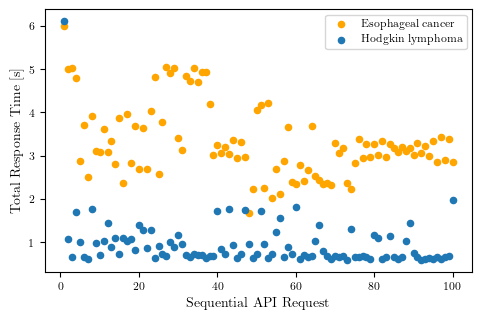

In [23]:
fig, ax = plt.subplots(figsize=set_size(width="thesis"))

loops = (
    pd.concat(
        [total_run_time_per_loop_hl.to_frame(), total_run_time_per_loop_es.to_frame()],
        keys=["Hodgkin lymphoma", "Esophageal carcinoma"],
        axis=1,
    )
    .droplevel(1, axis=1)
    .rename(index=lambda x: x + 1)
    .reset_index()
)

loops.plot(
    ax=ax,
    kind="scatter",
    x="loop",
    y="Esophageal carcinoma",
    color="orange",
    label="Esophageal cancer",
)
loops.plot(
    ax=ax, kind="scatter", x="loop", y="Hodgkin lymphoma", label="Hodgkin lymphoma"
)

ax.set_ylabel("Total Response Time [s]")
ax.set_xlabel("Sequential API Request")

if OVERWRITE_LATEX_OUTPUT:
    fig.savefig(PATH_LATEX_PLOT_OUTPUT / "total_response_time_per_loop_scatter.pdf")

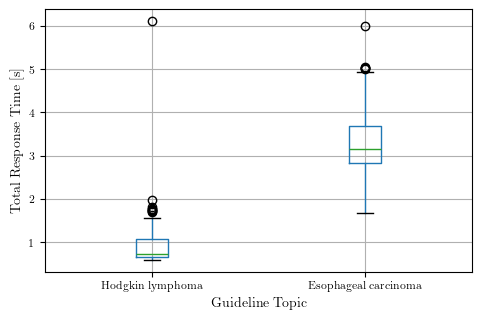

In [24]:
fig, ax = plt.subplots(figsize=set_size(width="thesis"))

loops.set_index("loop").boxplot(ax=ax)
ax.set_xlabel("Guideline Topic")
ax.set_ylabel("Total Response Time [s]")

if OVERWRITE_LATEX_OUTPUT:
    fig.savefig(PATH_LATEX_PLOT_OUTPUT / "total_response_time_per_loop_boxplot.pdf")

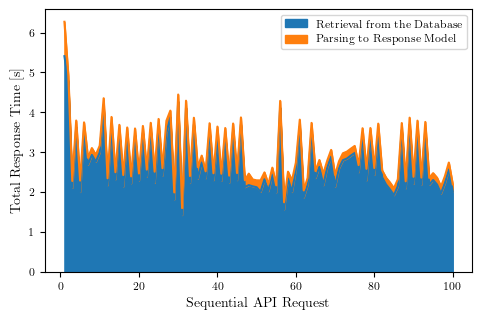

In [77]:
fig, ax = plt.subplots(figsize=set_size(width="thesis"))

pd.concat(
    [retrieval_time_per_loop_es, parsing_time_per_loop_es],
    axis=1,
    keys=["Retrieval from the Database", "Parsing to Response Model"],
).stack().groupby(level=[0]).sum().rename(index=lambda x: x + 1).plot(
    kind="area",
    # stacked=True,
    # rot=0,
    xlabel="Sequential API Request",
    ylabel="Total Response Time [s]",
    ax=ax,
)

if OVERWRITE_LATEX_OUTPUT:
    fig.savefig(PATH_LATEX_PLOT_OUTPUT / "response_time_broken_down_es.pdf")